# Imports

In [1]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA
import scipy
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs

# Exercise 1

## 1

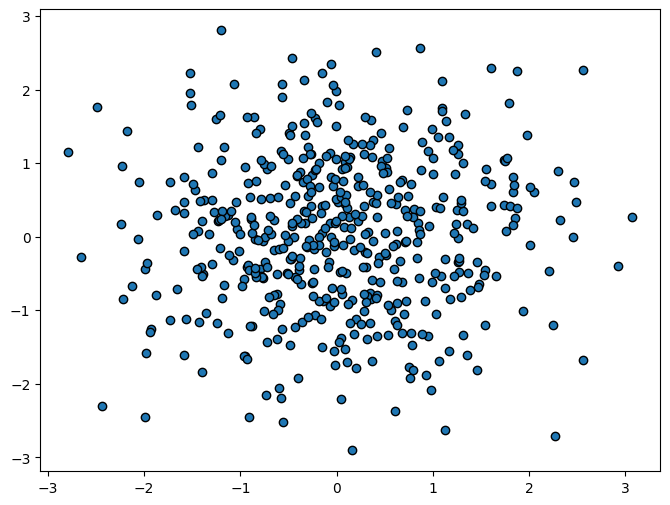

In [3]:
X, y = make_blobs(
    n_samples=500,
    n_features=2, 
    centers=1, 
    cluster_std=1.0,  
    center_box=(0.0, 0.0)
)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], edgecolor='k')
plt.show()

## 2

In [4]:
projection_vectors = []
for _ in range(5):
    vector = np.random.multivariate_normal(
        mean=(0, 0),
        cov=np.identity(2)
    )
    unit_vector = vector / np.linalg.norm(vector)   # normalize
    projection_vectors.append(unit_vector)

histograms = []
bin_edges = []
probabilities = []
for vector in projection_vectors:
    projections = X.dot(vector)

    hist, edges = np.histogram(projections, bins=10, range=(-5.0, 5.0))
    probs = hist / np.sum(hist)

    histograms.append(hist)
    bin_edges.append(edges)
    probabilities.append(probs)
    print(hist)
    print(edges)
    print(probs)
    print()
    # print(np.sum(hist))

[  0   0  13  68 163 160  83  13   0   0]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.    0.    0.026 0.136 0.326 0.32  0.166 0.026 0.    0.   ]

[  0   0  14  76 169 161  67  13   0   0]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.    0.    0.028 0.152 0.338 0.322 0.134 0.026 0.    0.   ]

[  0   1  11  82 160 171  62  11   2   0]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.    0.002 0.022 0.164 0.32  0.342 0.124 0.022 0.004 0.   ]

[  0   0  13  66 163 163  84  11   0   0]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.    0.    0.026 0.132 0.326 0.326 0.168 0.022 0.    0.   ]

[  0   1  10  82 159 173  62  11   2   0]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.    0.002 0.02  0.164 0.318 0.346 0.124 0.022 0.004 0.   ]



In [5]:
anomaly_scores = []
for sample in X:
    sample_scores = []

    for j in range(len(projection_vectors)):
        projection = sample.dot(projection_vectors[j])
        # print(projection)
        bin_index = np.digitize(projection, bin_edges[j]) - 1
        bin_index = min(max(bin_index, 0), len(histograms[j]) - 1)  # handle edge cases
        # print(bin_index)
        sample_scores.append(probabilities[j][bin_index])
        # print(histograms[j])
        # print(probabilities[j])
        # print(bin_edges[j])
        # print()

    # print()
    # print(sample_scores)
    anomaly_scores.append(np.mean(sample_scores))
    # print(anomaly_scores)

anomaly_scores = np.array(anomaly_scores)
print(anomaly_scores)

[0.3324 0.3324 0.2248 0.3324 0.3244 0.13   0.1628 0.3224 0.3324 0.3244
 0.3324 0.13   0.3244 0.3244 0.3244 0.2624 0.2    0.1628 0.3324 0.1628
 0.3324 0.2624 0.1628 0.1628 0.2564 0.3244 0.1628 0.3324 0.1628 0.3244
 0.2    0.3244 0.2564 0.3224 0.2872 0.13   0.3344 0.2248 0.1676 0.3324
 0.3224 0.3224 0.13   0.3324 0.3356 0.3244 0.3244 0.13   0.3244 0.0808
 0.3224 0.3244 0.13   0.3224 0.3356 0.3344 0.3324 0.3344 0.3244 0.3244
 0.3324 0.3324 0.1628 0.13   0.3244 0.3324 0.3244 0.1628 0.3244 0.3324
 0.3244 0.3324 0.218  0.1628 0.3324 0.218  0.3324 0.3244 0.3324 0.2624
 0.3244 0.1628 0.218  0.3324 0.0236 0.0652 0.13   0.3324 0.3324 0.3324
 0.3324 0.13   0.3244 0.3324 0.1628 0.3324 0.3212 0.016  0.1628 0.2948
 0.3324 0.3344 0.3324 0.3244 0.3324 0.3324 0.3324 0.13   0.3244 0.3244
 0.3324 0.3324 0.3244 0.3324 0.1628 0.3324 0.3344 0.2248 0.3244 0.3324
 0.3244 0.3344 0.3324 0.1628 0.1628 0.3344 0.1936 0.3244 0.3324 0.3324
 0.2248 0.1676 0.0864 0.2248 0.2936 0.2    0.3244 0.138  0.33   0.3324
 0.334

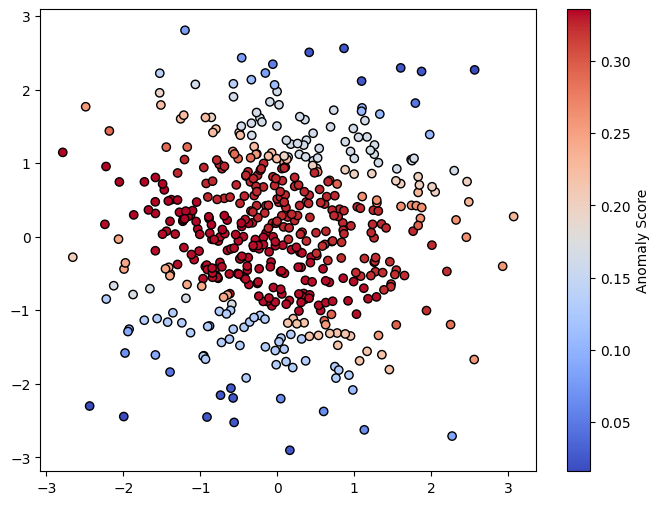

In [6]:
plt.figure(figsize=(8, 6))
scatter =plt.scatter(X[:, 0], X[:, 1], c=anomaly_scores, cmap='coolwarm', edgecolor='k')
plt.colorbar(scatter, label="Anomaly Score")
plt.show()

## 3

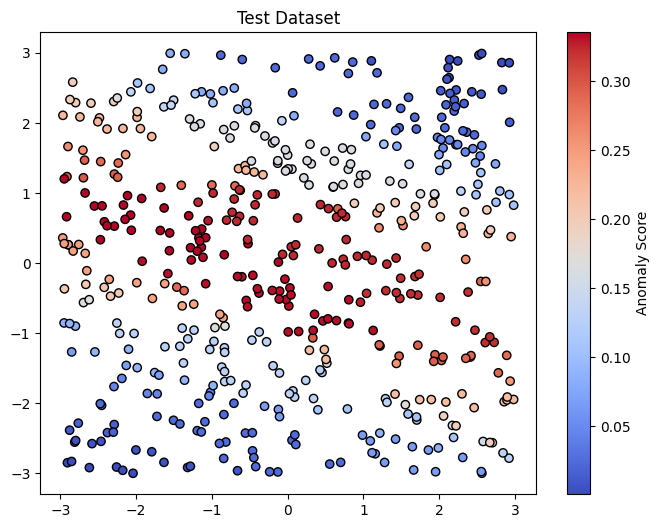

In [7]:
test_data = np.random.uniform(-3, 3, (500, 2))

test_anomaly_scores = []
for sample in test_data:
    sample_scores = []

    for j in range(len(projection_vectors)):
        projection = sample.dot(projection_vectors[j])
        bin_index = np.digitize(projection, bin_edges[j]) - 1
        bin_index = min(max(bin_index, 0), len(histograms[j]) - 1)
        sample_scores.append(probabilities[j][bin_index])
    
    test_anomaly_scores.append(np.mean(sample_scores))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=test_anomaly_scores, cmap='coolwarm', edgecolor='k')
plt.colorbar(scatter, label="Anomaly Score")
plt.title("Test Dataset")
plt.show()

# Exercise 2

## 1

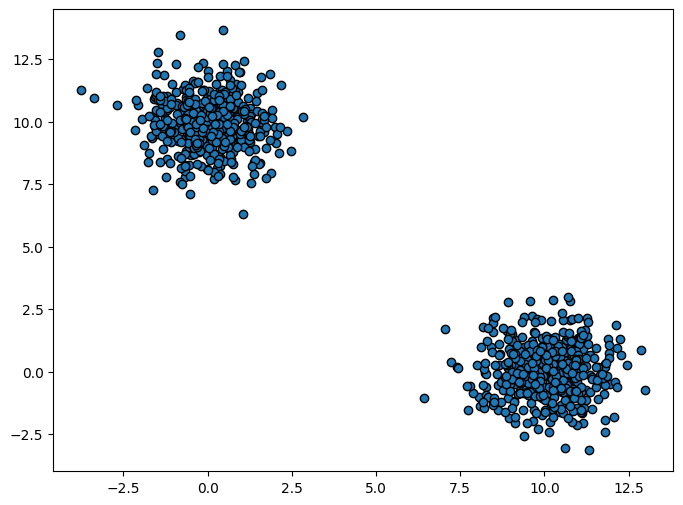

In [8]:
X, y = make_blobs(
    n_samples=500*2, 
    centers=[(10, 0), (0, 10)], 
    cluster_std=1, 
)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], edgecolor='k')
plt.show()

## 2

In [9]:
iforest_model = IForest(contamination=0.02)
iforest_model.fit(X)

test_data = np.random.uniform(-10, 20, (1000, 2))

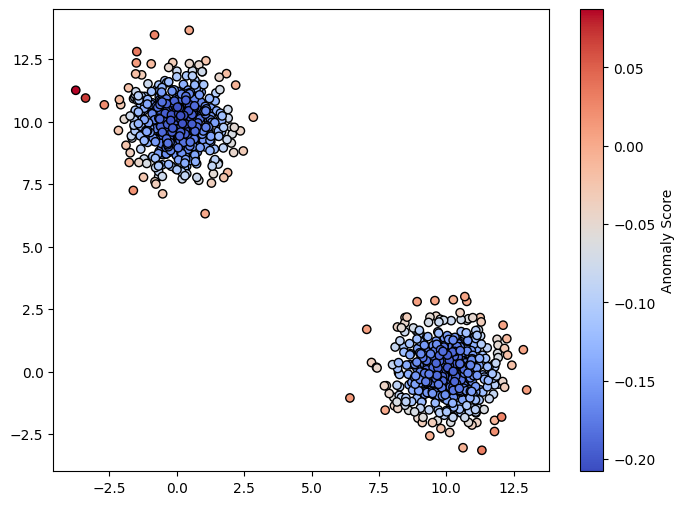

In [10]:
train_scores_iforest = iforest_model.decision_function(X)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=train_scores_iforest, cmap='coolwarm', edgecolor='k')
plt.colorbar(scatter, label="Anomaly Score")
plt.show()

## 3

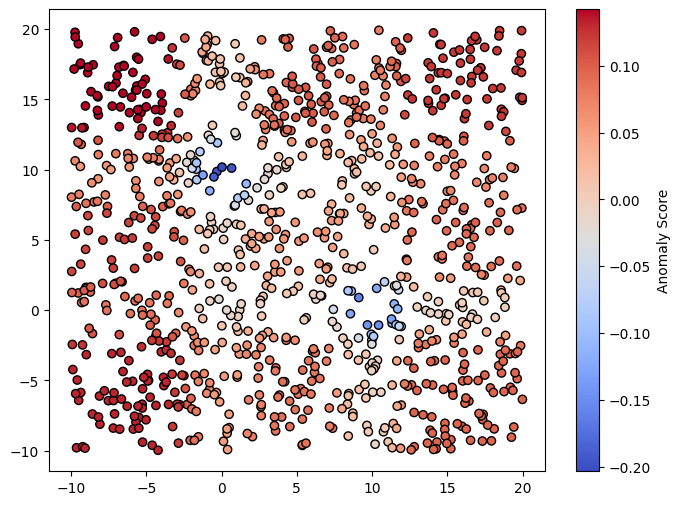

In [11]:
test_scores_iforest = iforest_model.decision_function(test_data)  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=test_scores_iforest, cmap='coolwarm', edgecolor='k')
plt.colorbar(scatter, label="Anomaly Score")
plt.show()

## 4

In [12]:
dif_model = DIF(contamination=0.02)
dif_model.fit(X)
test_scores_dif = dif_model.decision_function(test_data)

loda_model = LODA(contamination=0.02)
loda_model.fit(X)
test_scores_loda = loda_model.decision_function(test_data)

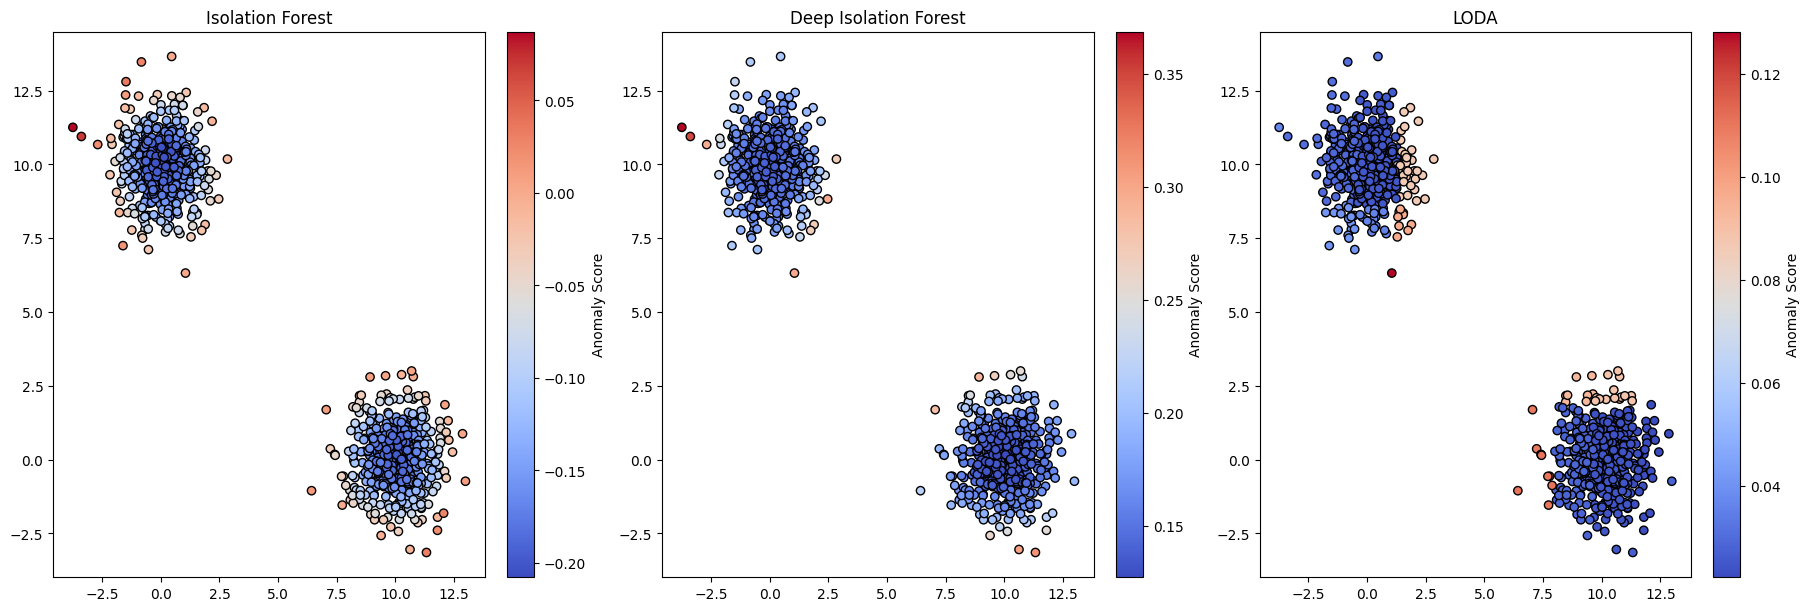

In [13]:
train_scores_dif = dif_model.decision_function(X)
train_scores_loda = loda_model.decision_function(X)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

sc1 = axs[0].scatter(X[:, 0], X[:, 1], c=train_scores_iforest, cmap='coolwarm', edgecolor='k', marker='o')
axs[0].set_title("Isolation Forest")
plt.colorbar(sc1, ax=axs[0], label="Anomaly Score")

sc2 = axs[1].scatter(X[:, 0], X[:, 1], c=train_scores_dif, cmap='coolwarm', edgecolor='k', marker='o')
axs[1].set_title("Deep Isolation Forest")
plt.colorbar(sc2, ax=axs[1], label="Anomaly Score")

sc3 = axs[2].scatter(X[:, 0], X[:, 1], c=train_scores_loda, cmap='coolwarm', edgecolor='k', marker='o')
axs[2].set_title("LODA")
plt.colorbar(sc3, ax=axs[2], label="Anomaly Score")

plt.show()

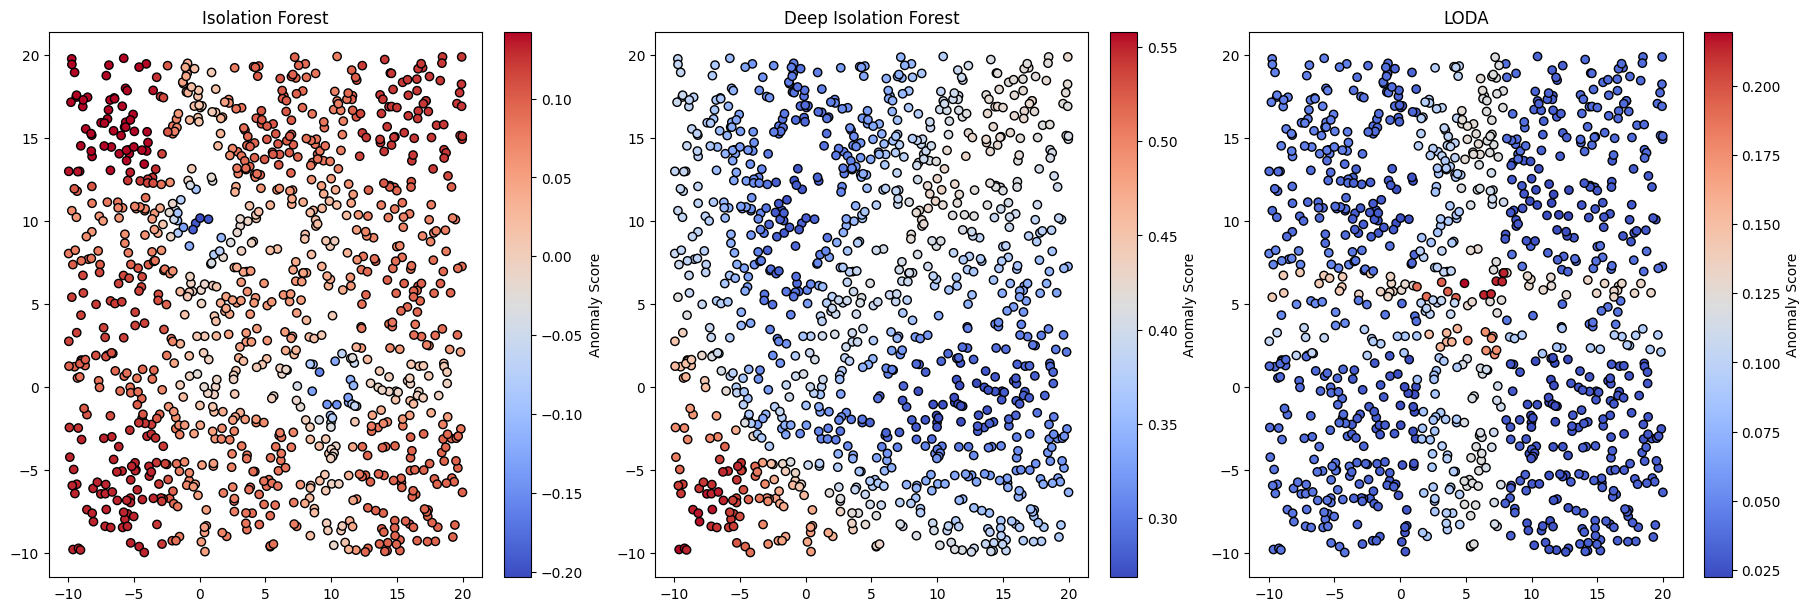

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

sc1 = axs[0].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_iforest, cmap='coolwarm', edgecolor='k')
axs[0].set_title("Isolation Forest")
plt.colorbar(sc1, ax=axs[0], label="Anomaly Score")

sc2 = axs[1].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_dif, cmap='coolwarm', edgecolor='k')
axs[1].set_title("Deep Isolation Forest")
plt.colorbar(sc2, ax=axs[1], label="Anomaly Score")

sc3 = axs[2].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_loda, cmap='coolwarm', edgecolor='k')
axs[2].set_title("LODA")
plt.colorbar(sc3, ax=axs[2], label="Anomaly Score")
    
plt.show()

## 5

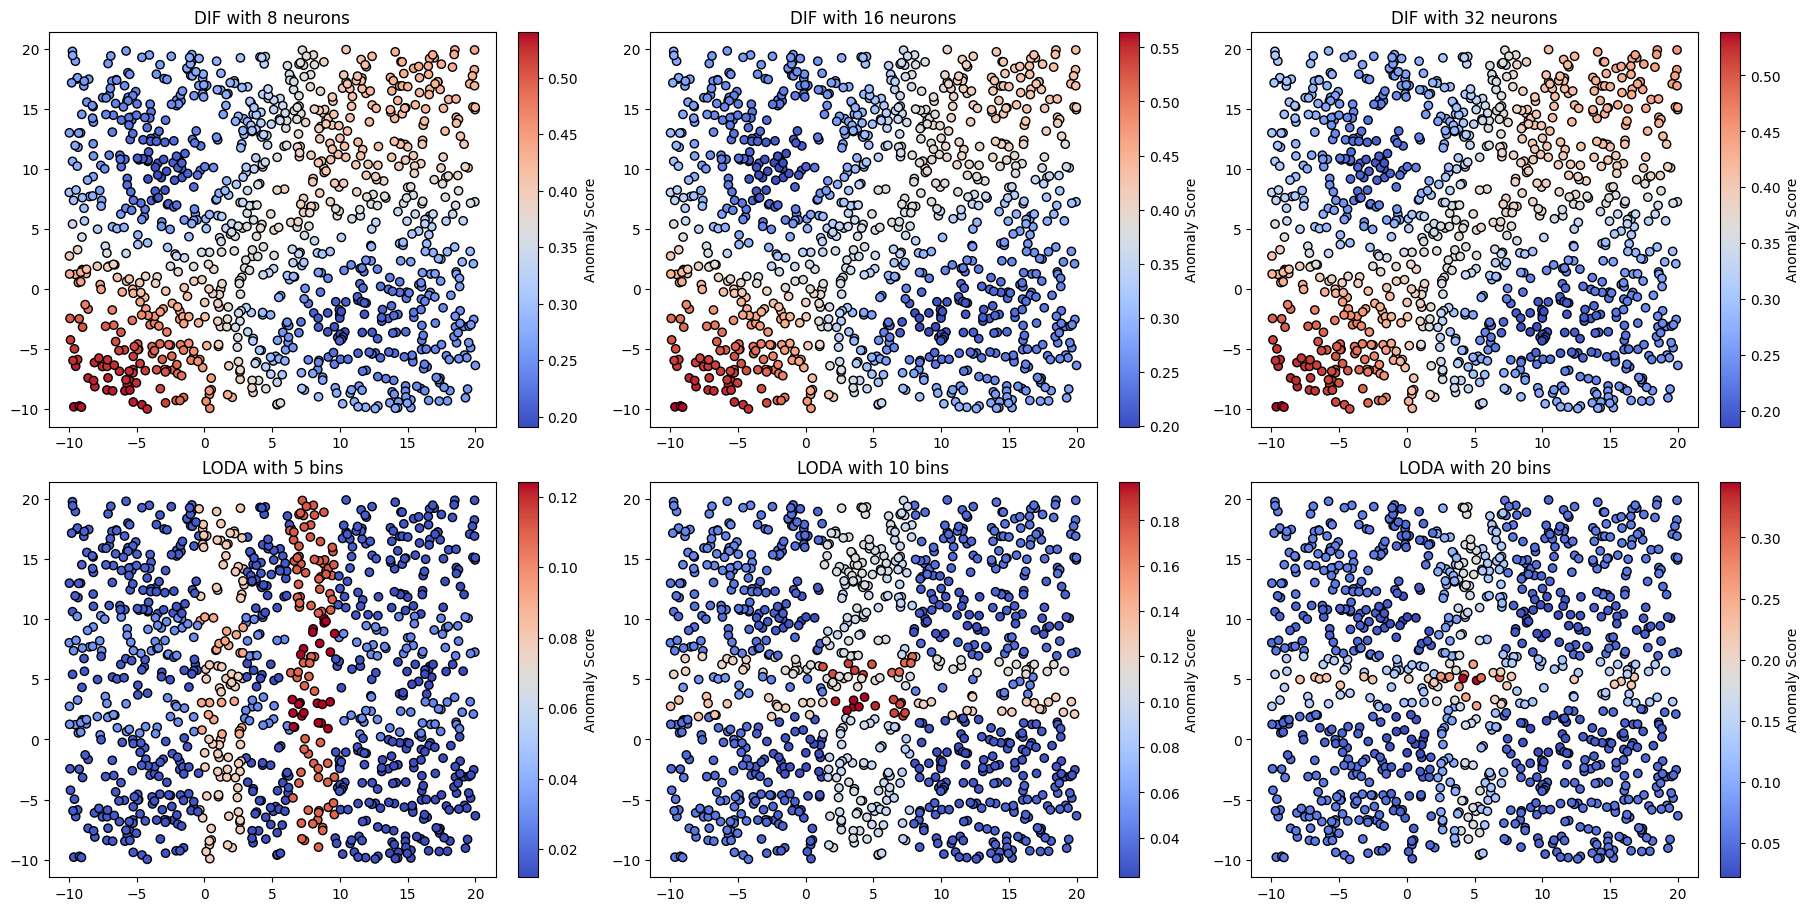

In [15]:
hidden_neurons_configs = [8, 16, 32]  
bin_configs = [5, 10, 20]   
contamination_rate = 0.02

fig, axs = plt.subplots(2, 3, figsize=(18, 9), constrained_layout=True)

for i, neurons in enumerate(hidden_neurons_configs):
    dif_model = DIF(contamination=contamination_rate, hidden_neurons=[neurons])
    dif_model.fit(X)
    dif_scores = dif_model.decision_function(test_data)
    
    sc = axs[0, i].scatter(test_data[:, 0], test_data[:, 1], c=dif_scores, cmap='coolwarm', edgecolor='k')
    axs[0, i].set_title(f"DIF with {neurons} neurons")
    plt.colorbar(sc, ax=axs[0, i], label="Anomaly Score")

for i, bins in enumerate(bin_configs):
    loda_model = LODA(contamination=contamination_rate, n_bins=bins)
    loda_model.fit(X)
    loda_scores = loda_model.decision_function(test_data)
    
    sc = axs[1, i].scatter(test_data[:, 0], test_data[:, 1], c=loda_scores, cmap='coolwarm', edgecolor='k')
    axs[1, i].set_title(f"LODA with {bins} bins")
    plt.colorbar(sc, ax=axs[1, i], label="Anomaly Score")
plt.show()

# The score maps for LODA look this way because of the random projections that result in artifacts resembling grid-like patterns

## 6

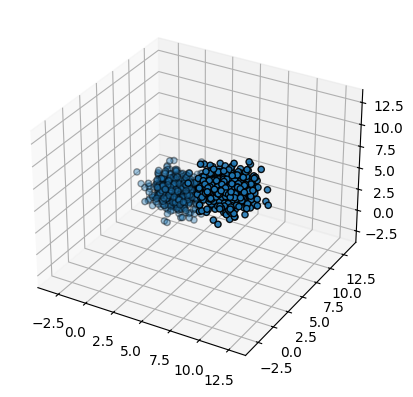

In [16]:
X, _ = make_blobs(
    n_samples=1000, 
    n_features=3,
    centers=[(0, 10, 0), (10, 0, 10)], 
    cluster_std=1
)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolors='k')
plt.show()

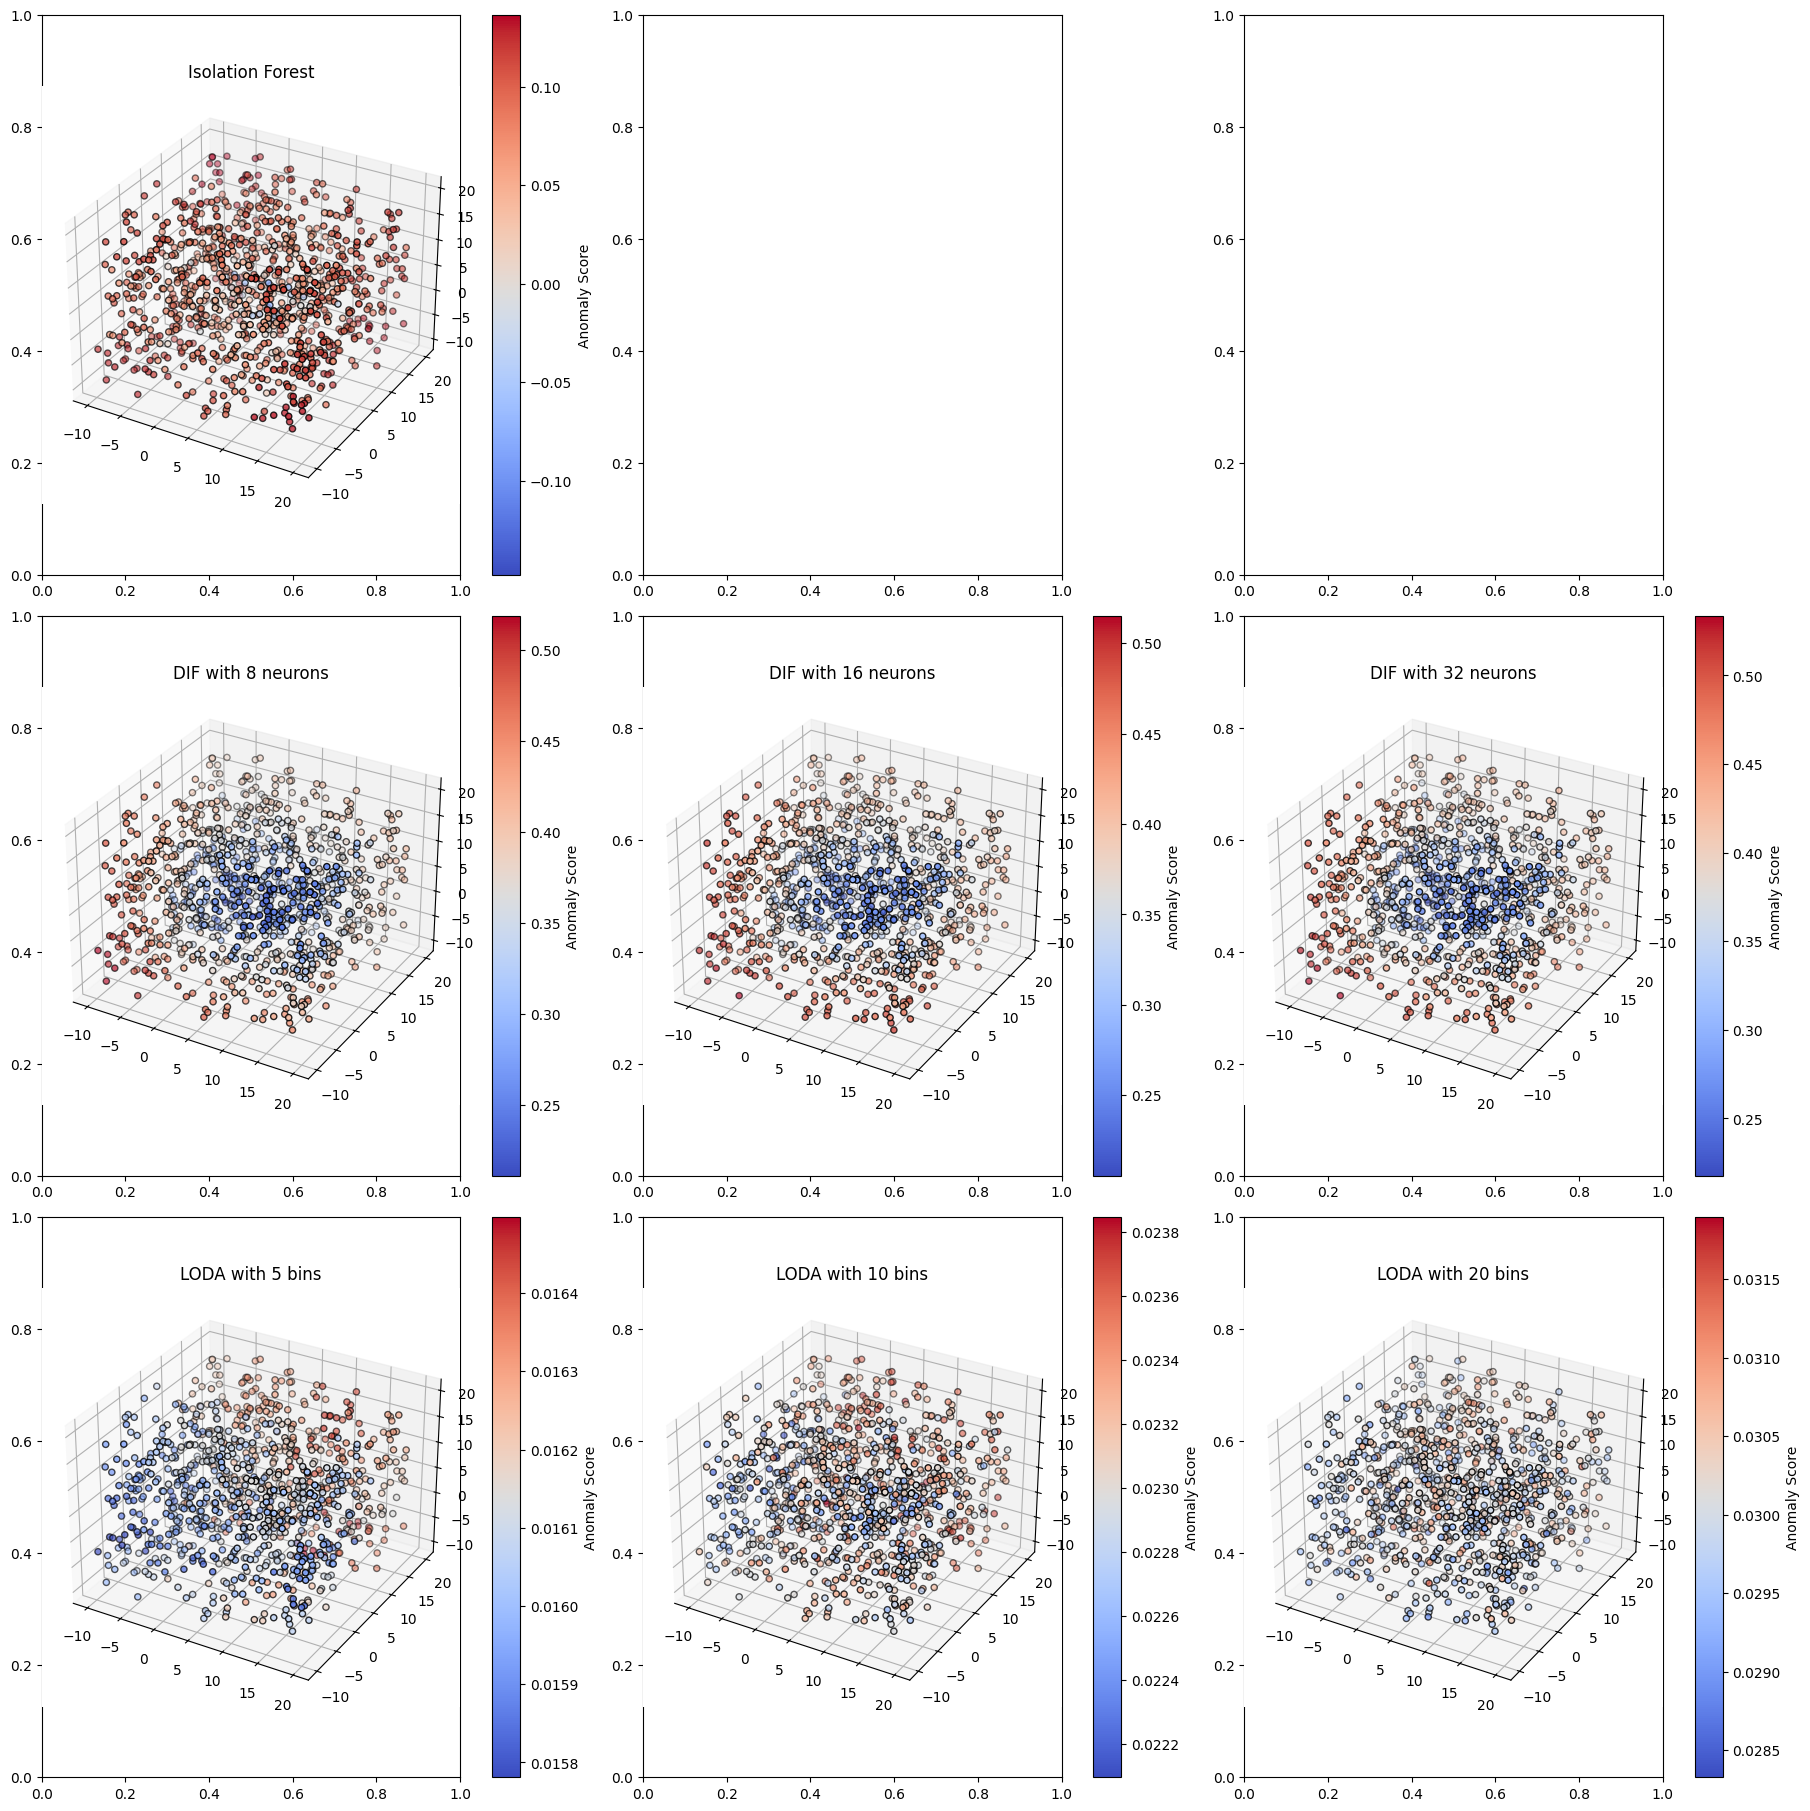

In [17]:
test_data = np.random.uniform(-10, 20, (1000, 3))

hidden_neurons_configs = [8, 16, 32]  
bin_configs = [5, 10, 20]             
contamination_rate = 0.02

fig, axs = plt.subplots(3, 3, figsize=(18, 18), constrained_layout=True)

iforest = IForest(contamination=contamination_rate, random_state=42)
iforest.fit(X)
iforest_scores = iforest.decision_function(test_data)
ax = fig.add_subplot(3, 3, 1, projection='3d')
sc = ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=iforest_scores, cmap='coolwarm', edgecolors='k')
ax.set_title("Isolation Forest")
fig.colorbar(sc, ax=ax, label="Anomaly Score")

for i, neurons in enumerate(hidden_neurons_configs):
    dif_model = DIF(contamination=contamination_rate, hidden_neurons=[neurons])
    dif_model.fit(X)
    dif_scores = dif_model.decision_function(test_data)

    ax = fig.add_subplot(3, 3, i + 4, projection='3d')
    sc = ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=dif_scores, cmap='coolwarm', edgecolors='k')
    ax.set_title(f"DIF with {neurons} neurons")
    fig.colorbar(sc, ax=ax, label="Anomaly Score")

for i, bins in enumerate(bin_configs):
    loda_model = LODA(contamination=contamination_rate, n_bins=bins)
    loda_model.fit(test_data)
    loda_scores = loda_model.decision_function(test_data)

    ax = fig.add_subplot(3, 3, i + 7, projection='3d')
    sc = ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=loda_scores, cmap='coolwarm', edgecolors='k')
    ax.set_title(f"LODA with {bins} bins")
    fig.colorbar(sc, ax=ax, label="Anomaly Score")

plt.show()

# Exercise 3

## 1

In [18]:
data = scipy.io.loadmat('shuttle.mat')
X = data['X']
y = data['y'].flatten()

# Normalize data 
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

## 2

In [19]:
iforest_ba_scores, iforest_auc_scores = [], []
loda_ba_scores, loda_auc_scores = [], []
dif_ba_scores, dif_auc_scores = [], []

for i in range(10):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.4, random_state=i)
    
    iforest = IForest(contamination=0.2)
    iforest.fit(X_train)
    iforest_preds = iforest.predict(X_test)  # Predictions (1 for anomaly, 0 for normal)
    iforest_scores = iforest.decision_function(X_test)  # Anomaly scores
    iforest_ba_scores.append(balanced_accuracy_score(y_test, iforest_preds))
    iforest_auc_scores.append(roc_auc_score(y_test, iforest_scores))
    
    loda = LODA(contamination=0.2, n_bins=15)
    loda.fit(X_train)
    loda_preds = loda.predict(X_test)
    loda_scores = loda.decision_function(X_test)
    loda_ba_scores.append(balanced_accuracy_score(y_test, loda_preds))
    loda_auc_scores.append(roc_auc_score(y_test, loda_scores))
    
    dif = DIF(contamination=0.2, hidden_neurons=[16])
    dif.fit(X_train)
    dif_preds = dif.predict(X_test)
    dif_scores = dif.decision_function(X_test)
    dif_ba_scores.append(balanced_accuracy_score(y_test, dif_preds))
    dif_auc_scores.append(roc_auc_score(y_test, dif_scores))

print("Isolation Forest - Mean Balanced Accuracy:", np.mean(iforest_ba_scores))
print("Isolation Forest - Mean ROC AUC:", np.mean(iforest_auc_scores))

print("LODA - Mean Balanced Accuracy:", np.mean(loda_ba_scores))
print("LODA - Mean ROC AUC:", np.mean(loda_auc_scores))

print("DIF - Mean Balanced Accuracy:", np.mean(dif_ba_scores))
print("DIF - Mean ROC AUC:", np.mean(dif_auc_scores))


Isolation Forest - Mean Balanced Accuracy: 0.9280955379180071
Isolation Forest - Mean ROC AUC: 0.9968926989964245
LODA - Mean Balanced Accuracy: 0.6965643484901707
LODA - Mean ROC AUC: 0.6732158545692267
DIF - Mean Balanced Accuracy: 0.750700608250583
DIF - Mean ROC AUC: 0.9649910159529698
